In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the preprocessed EEG data
file_dir = 'Data'
x_path = os.path.join(file_dir, 'x.npy')
y_path = os.path.join(file_dir, 'y.npy')
X = np.load(x_path)
y = np.load(y_path)

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Create custom datasets and data loaders
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the EEGNet model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the client-side and server-side models for different split scenarios
class ClientModel1(nn.Module):
    def __init__(self):
        super(ClientModel1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        return x

class ServerModel1(nn.Module):
    def __init__(self):
        super(ServerModel1, self).__init__()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        # Calculate the output shape of the previous layers
        self.fc1_input_size = self.calculate_fc1_input_size()
        
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def calculate_fc1_input_size(self):
        # Create a dummy input tensor to pass through the convolutional layers
        dummy_input = torch.zeros(1, 32, 1280)  # Adjust the shape based on your data
        
        # Pass the dummy input through the convolutional layers
        x = self.conv2(dummy_input)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = self.conv3(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = self.conv4(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        
        # Calculate the flattened size
        flattened_size = x.view(x.size(0), -1).size(1)
        
        return flattened_size

    def forward(self, x):
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        
        # Flatten the output of the previous layers
        x = x.view(x.size(0), -1)
        
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel2(nn.Module):
    def __init__(self):
        super(ClientModel2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        return x

class ServerModel2(nn.Module):
    def __init__(self):
        super(ServerModel2, self).__init__()
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel3(nn.Module):
    def __init__(self):
        super(ClientModel3, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        return x

# class ServerModel3(nn.Module):
#     def __init__(self):
#         super(ServerModel3, self).__init__()
#         self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(256 * 80, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 1)

#     def forward(self, x):
#         x = nn.functional.relu(self.conv4(x))
#         x = nn.functional.max_pool1d(x, kernel_size=2)
#         x = x.view(x.size(0), -1)
#         x = nn.functional.relu(self.fc1(x))
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


class ServerModel3(nn.Module):
    def __init__(self):
        super(ServerModel3, self).__init__()
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)  # Update the input size based on the client_output dimensions
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to evaluate the model and calculate privacy metrics
def evaluate_model(client_model, server_model, dataloader, scenario):
    client_model.eval()
    server_model.eval()
    y_true = []
    y_pred = []
    cosine_similarities = []
    pearson_correlations = []
    spearman_correlations = []
    mutual_info_scores = []
    kl_divergences = []
    js_divergences = []
    euclidean_distances = []

    with torch.no_grad():
        for data, target in dataloader:
            client_output = client_model(data)
            server_output = server_model(client_output)
            predictions = (torch.sigmoid(server_output) > 0.5).float().squeeze()
            y_true.extend(target.numpy())
            y_pred.extend(predictions.numpy())

            raw_signal = data.view(data.size(0), -1).numpy()
            intermediate_output = client_output.view(client_output.size(0), -1)
            intermediate_output = nn.functional.interpolate(intermediate_output.unsqueeze(1), size=raw_signal.shape[1], mode='linear', align_corners=False)
            intermediate_output = intermediate_output.squeeze(1).numpy()

            cosine_sim = cosine_similarity(raw_signal, intermediate_output).diagonal()
            cosine_similarities.extend(cosine_sim)

            pearson_corr = np.array([pearsonr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
            pearson_correlations.extend(pearson_corr)

            spearman_corr = np.array([spearmanr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
            spearman_correlations.extend(spearman_corr)

            mutual_info = np.array([mutual_info_score(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            mutual_info_scores.extend(mutual_info)

            # Compute KL divergence
            kl_div = np.mean([entropy(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            kl_divergences.append(kl_div)

            # Compute JS divergence
            js_div = np.mean([0.5 * (entropy(raw_signal[i], intermediate_output[i]) + entropy(intermediate_output[i], raw_signal[i])) for i in range(data.size(0))])
            js_divergences.append(js_div)

            # Compute Euclidean distance
            euclidean_dist = np.mean([euclidean(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            euclidean_distances.append(euclidean_dist)


    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    avg_cosine_similarity = np.mean(cosine_similarities)
    avg_pearson_correlation = np.mean(pearson_correlations)
    avg_spearman_correlation = np.mean(spearman_correlations)
    avg_mutual_info_score = np.mean(mutual_info_scores)
    
    client_model_size = sum(p.numel() for p in client_model.parameters())
    avg_kl_divergence = np.mean(kl_divergences)
    avg_js_divergence = np.mean(js_divergences)
    avg_euclidean_distance = np.mean(euclidean_distances)

    print(f"Scenario {scenario}:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")
    print(f"Average Pearson Correlation: {avg_pearson_correlation:.4f}")
    print(f"Average Spearman Correlation: {avg_spearman_correlation:.4f}")
    print(f"Average Mutual Information Score: {avg_mutual_info_score:.4f}")
    print(f"Client Model Size: {client_model_size}")
    print(f"Average KL Divergence: {avg_kl_divergence:.4f}")
    print(f"Average JS Divergence: {avg_js_divergence:.4f}")
    print(f"Average Euclidean Distance: {avg_euclidean_distance:.4f}")
    print()
    print()

    return accuracy, avg_cosine_similarity, avg_pearson_correlation, avg_spearman_correlation, avg_mutual_info_score, avg_kl_divergence, avg_js_divergence, avg_euclidean_distance, client_model_size

# Train and evaluate the model for different split scenarios
scenarios = [
    (ClientModel1(), ServerModel1(), "Breaking at Conv1"),
    (ClientModel2(), ServerModel2(), "Breaking at Conv2"),
    (ClientModel3(), ServerModel3(), "Breaking at Conv3"),
    # (EEGNet(), None, "No Split")
]

results = []

for i, (client_model, server_model, scenario_name) in enumerate(scenarios):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list(client_model.parameters()) + (list(server_model.parameters()) if server_model else []), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        client_model.train()
        if server_model:
            server_model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_dataloader):
            client_output = client_model(data)
            if server_model:
                server_output = server_model(client_output)
                loss = criterion(server_output.squeeze(), target)
            else:
                loss = criterion(client_output.squeeze(), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        print(f"Scenario {i+1}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    print(f"\nEvaluation Results for Scenario {i+1}:")
    accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, model_size = evaluate_model(client_model, server_model, test_dataloader, i+1)
    results.append((scenario_name, accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, model_size))

# Print the summary of results
print("Summary of Results:")
for scenario_name, accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, model_size in results:
    print(f"Scenario: {scenario_name}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Cosine Similarity: {cosine_sim:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    

In [9]:
enumerate(scenarios)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the relevant data from the results
scenarios = [result[0] for result in results]
accuracies = [result[1] for result in results]
cosine_similarities = [result[2] for result in results]
pearson_correlations = [result[3] for result in results]
spearman_correlations = [result[4] for result in results]
mutual_info_scores = [result[5] for result in results]
model_sizes = [result[6] for result in results]

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Plot accuracy
axs[0, 0].bar(scenarios, accuracies)
axs[0, 0].set_title('Test Accuracy')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot cosine similarity
axs[0, 1].bar(scenarios, cosine_similarities)
axs[0, 1].set_title('Cosine Similarity')
axs[0, 1].set_ylabel('Similarity')
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot Pearson correlation
axs[0, 2].bar(scenarios, pearson_correlations)
axs[0, 2].set_title('Pearson Correlation')
axs[0, 2].set_ylabel('Correlation')
axs[0, 2].tick_params(axis='x', rotation=45)

# Plot Spearman correlation
axs[1, 0].bar(scenarios, spearman_correlations)
axs[1, 0].set_title('Spearman Correlation')
axs[1, 0].set_ylabel('Correlation')
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot mutual information score
axs[1, 1].bar(scenarios, mutual_info_scores)
axs[1, 1].set_title('Mutual Information Score')
axs[1, 1].set_ylabel('Score')
axs[1, 1].tick_params(axis='x', rotation=45)

# Plot client model size
axs[1, 2].bar(scenarios, model_sizes)
axs[1, 2].set_title('Client Model Size')
axs[1, 2].set_ylabel('Number of Parameters')
axs[1, 2].tick_params(axis='x', rotation=45)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

NameError: name 'results' is not defined

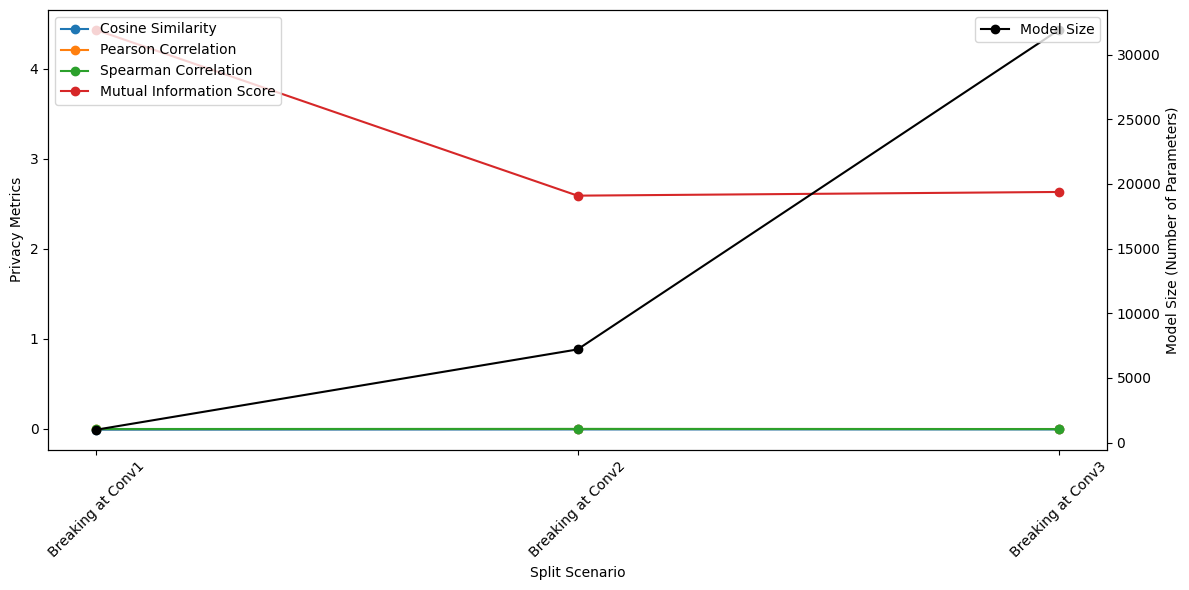

In [22]:
import matplotlib.pyplot as plt

# Extract the relevant data from the results
scenarios = [result[0] for result in results]
accuracies = [result[1] for result in results]
cosine_similarities = [result[2] for result in results]
pearson_correlations = [result[3] for result in results]
spearman_correlations = [result[4] for result in results]
mutual_info_scores = [result[5] for result in results]
model_sizes = [result[6] for result in results]

# Create a figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot privacy metrics on the left y-axis
ax1.plot(scenarios, cosine_similarities, marker='o', label='Cosine Similarity')
ax1.plot(scenarios, pearson_correlations, marker='o', label='Pearson Correlation')
ax1.plot(scenarios, spearman_correlations, marker='o', label='Spearman Correlation')
ax1.plot(scenarios, mutual_info_scores, marker='o', label='Mutual Information Score')
ax1.set_xlabel('Split Scenario')
ax1.set_ylabel('Privacy Metrics')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create a twin y-axis on the right for model size
ax2 = ax1.twinx()
ax2.plot(scenarios, model_sizes, marker='o', color='black', label='Model Size')
ax2.set_ylabel('Model Size (Number of Parameters)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

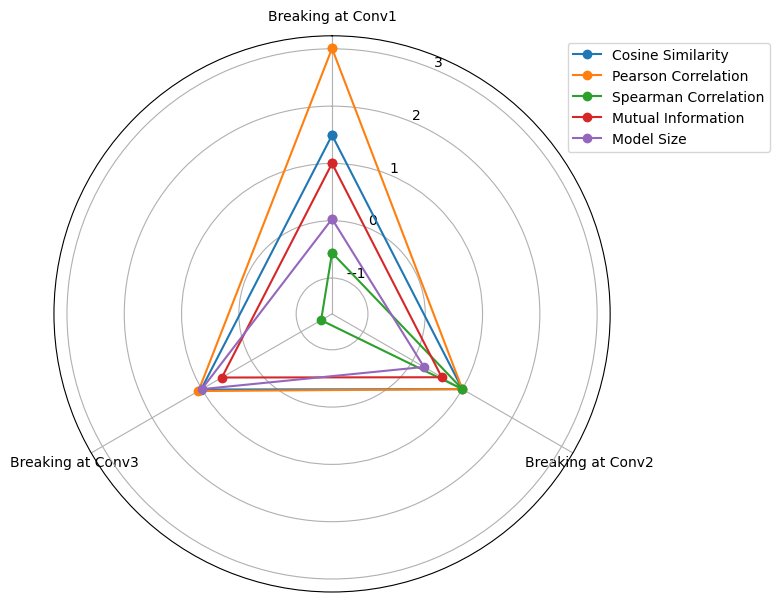

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the relevant data from the results
scenarios = [result[0] for result in results]
accuracies = [result[1] for result in results]
cosine_similarities = [result[2] for result in results]
pearson_correlations = [result[3] for result in results]
spearman_correlations = [result[4] for result in results]
mutual_info_scores = [result[5] for result in results]
model_sizes = [result[6] for result in results]

# Normalize the data
cosine_similarities = np.array(cosine_similarities) / np.max(cosine_similarities)
pearson_correlations = np.array(pearson_correlations) / np.max(pearson_correlations)
spearman_correlations = np.array(spearman_correlations) / np.max(spearman_correlations)
mutual_info_scores = np.array(mutual_info_scores) / np.max(mutual_info_scores)
model_sizes = np.array(model_sizes) / np.max(model_sizes)

# Create a radar chart
fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(8, 8))

angles = np.linspace(0, 2*np.pi, len(scenarios), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

for metric, values in zip(['Cosine Similarity', 'Pearson Correlation', 'Spearman Correlation', 'Mutual Information', 'Model Size'],
                          [cosine_similarities, pearson_correlations, spearman_correlations, mutual_info_scores, model_sizes]):
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, marker='o', label=metric)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels=scenarios)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()